In [1]:
image_size = 512
backbone='efficientdetv2_ds'
checkpoint='axial_detection_effdet_134352-epoch-52'

In [2]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import sys

import pydicom
import pylibjpeg

effdet_path = "../third/effdet"
sys.path.append(effdet_path)
from effdet import create_model

timm_path = "../third/timm-pytorch-image-models"
sys.path.append(timm_path)
import timm
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from matplotlib import patches
import sklearn
import os
from tqdm import tqdm

omega_path = "../third/omegaconf"
sys.path.append(omega_path)
from omegaconf import OmegaConf
import glob
import sklearn
import math
import random
import numpy as np

from PIL import Image

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torchvision import transforms
import torchvision.models as models
import torchvision.transforms as T
import torchvision.transforms.functional as TF
# from transformers import get_cosine_schedule_with_warmup

import warnings

warnings.filterwarnings('ignore')
from sklearn import metrics, model_selection, preprocessing

# from sklearn.model_selection import GroupKFold


# pos_weight = torch.tensor(pos_weight)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"

IMAGES_DIR = os.path.join(DATA_DIR, 'train_images')

In [4]:
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
test_df

,row_id,StudyInstanceUID,prediction_type
0,1.2.826.0.1.3680043.10197_C1,1.2.826.0.1.3680043.10197,C1
1,1.2.826.0.1.3680043.10454_C1,1.2.826.0.1.3680043.10454,C1
2,1.2.826.0.1.3680043.10690_C1,1.2.826.0.1.3680043.10690,C1


## read dcm file


In [5]:
def rescale_img_to_hu(dcm_ds):
    """Rescales the image to Hounsfield unit.
    """
    return dcm_ds.pixel_array * dcm_ds.RescaleSlope + dcm_ds.RescaleIntercept


def read_dcm(patient_dir, num_instance):
    dcm_path = os.path.join(patient_dir, f"{int(num_instance)}.dcm")
    ds = pydicom.dcmread(dcm_path)
    img2d = rescale_img_to_hu(ds)
    return normalize_hu(img2d)

def read_patient_dcm(patient_dir):
    """
    여기서 이미지를 정상적인 순서로 돌려 놓는다
    :param patient_dir:
    :return:
    """
    num_slices = len(glob.glob(patient_dir + "/*.dcm"))
    print(f"total slices {num_slices}")
    imgs = np.zeros((num_slices, 512, 512))
    image_positions = np.zeros((num_slices, 3))
    image_orientations = np.zeros((num_slices, 6))
    pixel_spacings = np.zeros((num_slices, 2))
    slice_thicknesses = np.zeros((num_slices, 1))

    ignore_count = 1
    for i in range(num_slices):
        dcm_path = os.path.join(patient_dir, f"{i+ignore_count}.dcm")
        while os.path.exists(dcm_path) == False:
            ignore_count += 1
            dcm_path = os.path.join(patient_dir, f"{i+ignore_count}.dcm")
        ds = pydicom.dcmread(dcm_path)

        image_positions[i, :] = ds.ImagePositionPatient
        image_orientations[i, :] = ds.ImageOrientationPatient
        pixel_spacings[i, :] = ds.PixelSpacing
        slice_thicknesses[i, :] = ds.SliceThickness

        img2d = rescale_img_to_hu(ds)

        imgs[i] = img2d

    is_flip = False
    # check z is in good direction
    if image_positions[0, 2] < image_positions[1, 2]:
        is_flip = True
        # flip image in z direction
        imgs = np.flip(imgs, axis=0)
        image_positions = np.flip(image_positions, axis=0)
        pixel_spacings = np.flip(pixel_spacings, axis=0)
        slice_thicknesses = np.flip(slice_thicknesses, axis=0)

    aspect = calculate_aspect(image_positions, pixel_spacings)
        
    return imgs, aspect


def normalize_hu(data):
    # normalize to 0-1
    # return (data - data.min()) / data.max()
    data = np.clip(data, a_min=-2242, a_max=2242) / 4484 + 0.5
    return data

def calculate_aspect(image_positions, pixel_spacings):
    """
    calculate z aspect, z 를 몇배로 늘여야 하는가야
    :param image_positions:
    :param pixel_spacings:
    :return:
    """
    height = image_positions[0, 2] - image_positions[1, 2]
    pixel_spacing = pixel_spacings[0, 0]
    aspect = height / pixel_spacing
    return aspect

## get boundary

In [6]:
class BoundaryDataTransform(nn.Module):
    def __init__(self, image_size=256):
        super().__init__()

        self.transform = T.Compose([
            T.Resize(image_size),
            T.ToTensor(),
            T.Normalize(0.5, 0.5)
        ])

    def forward(self, x):
        
        x = TF.center_crop(x, max(x.width, x.height))
        x = self.transform(x)

        return x


def get_sagittal_boundary_model():
    model = models.efficientnet_v2_m(pretrained=False)
    conv1_weight = model.features[0][0].weight
    conv1_weight = conv1_weight.mean(dim=1).unsqueeze(1)

    model.features[0][0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=1, padding='same', bias=False)
    model.features[0][0].weight = nn.Parameter(conv1_weight, requires_grad=True)

    model.avgpool = nn.Sequential(
        nn.MaxPool2d(2, 2),
        nn.Flatten()
    )
    # model.classifier[1] = nn.Linear(1280, 4, bias=True)
    model.classifier[1] = nn.Sequential(
        nn.Linear(81920, 1024, bias=True),
        nn.ReLU(),
        nn.Linear(1024, 4, bias=True)
    )
    state = torch.load(os.path.join(DATA_DIR, 'checkpoint', 'xray_effnet-m_boundary_193121-epoch-300.pth'))
    model.load_state_dict(state["model"])
    model = model.to(device).eval()
    
    
    transform = BoundaryDataTransform(256)
    
    return model, transform

def get_coronal_boundary_model():
    model = models.efficientnet_v2_m(pretrained=False)
    conv1_weight = model.features[0][0].weight
    conv1_weight = conv1_weight.mean(dim=1).unsqueeze(1)

    model.features[0][0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=1, padding='same', bias=False)
    model.features[0][0].weight = nn.Parameter(conv1_weight, requires_grad=True)

    model.avgpool = nn.Sequential(
        nn.MaxPool2d(2, 2),
        nn.Flatten()
    )
    # model.classifier[1] = nn.Linear(1280, 4, bias=True)
    model.classifier[1] = nn.Sequential(
        nn.Linear(81920, 1024, bias=True),
        nn.ReLU(),
        nn.Linear(1024, 4, bias=True)
    )

    state = torch.load(os.path.join(DATA_DIR, 'checkpoint', 'coronal_effnet-m_boundary_185858-epoch-300.pth'))
    model.load_state_dict(state["model"])
    model = model.to(device).eval()
    transform = BoundaryDataTransform(256)
    
    return model, transform


sagittal_boundary_model, sb_transform = get_sagittal_boundary_model()
coronal_boundary_model, cb_transform = get_coronal_boundary_model()

In [446]:
UID = '1.2.826.0.1.3680043.14833'
imgs, aspect = read_patient_dcm(os.path.join(IMAGES_DIR, UID))
print(imgs.shape)
print(aspect)

total slices 256
(256, 512, 512)
2.461540885209487


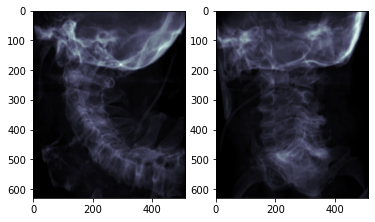

In [447]:
xray_imgs = np.clip(imgs, a_min=0, a_max=2242)
coronal_xray = xray_imgs.mean(axis=1)
coronal_xray = coronal_xray / coronal_xray.max()
coronal_img = Image.fromarray(np.uint8(coronal_xray * 255), 'L')
coronal_img = coronal_img.resize((coronal_img.width, int(coronal_img.height * aspect)))

sagittal_xray = xray_imgs.mean(axis=2)
sagittal_xray = sagittal_xray / sagittal_xray.max()
sagittal_img = Image.fromarray(np.uint8(sagittal_xray * 255), 'L')
sagittal_img = sagittal_img.resize((sagittal_img.width, int(sagittal_img.height * aspect)))

_, axs = plt.subplots(1, 2)
axs[0].imshow(sagittal_img, cmap='bone')
axs[1].imshow(coronal_img, cmap='bone')

In [448]:
def square_crop_position(crop_box, image_size=512):
    """
    crop box 를 정방형으로 만들어준다.
    :param left:
    :param top:
    :param right:
    :param bottom:
    :param image_size:
    :return:
    """
    left, top, right, bottom = crop_box
    w, h = right - left, bottom - top

    if h > w:
        left_pad = (h - w) // 2
        right_pad = h - w - left_pad
        left -= left_pad
        right += right_pad

        if left < 0:
            right -= left
            left = 0
        elif right > image_size:
            left -= right - image_size
            right = image_size
    else:
        top_pad = (w - h) // 2
        bottom_pad = w - h - top_pad
        top -= top_pad
        bottom += bottom_pad

        if top < 0:
            bottom -= top
            top = 0
        elif bottom > image_size:
            top -= bottom - image_size
            bottom = image_size
    return left, top, right, bottom

[ 88.329575  64.0173   429.7122   497.076   ] [ 90.764854  68.026825 401.4605   496.225   ]
[75, 88, 417, 429]
26 201


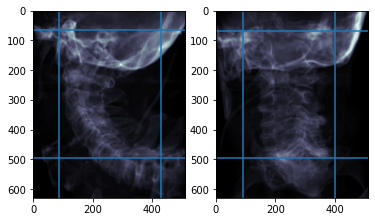

In [449]:
sagittal_tensor = sb_transform(sagittal_img)
coronal_tensor = cb_transform(coronal_img)
with torch.no_grad():
    sagittal_boundary = sagittal_boundary_model(sagittal_tensor.unsqueeze(0).to(device))[0].sigmoid().cpu().numpy() * 512
    coronal_boundary = coronal_boundary_model(coronal_tensor.unsqueeze(0).to(device))[0].sigmoid().cpu().numpy() * 512
    print(sagittal_boundary, coronal_boundary)
    
    _, axs = plt.subplots(1, 2)
    
    # sagittal_boundary[0] = 100
    
    axs[0].imshow(sagittal_img, cmap='bone')
    axs[0].axvline(sagittal_boundary[0])
    axs[0].axvline(sagittal_boundary[2])
    axs[0].axhline(sagittal_boundary[1])
    axs[0].axhline(sagittal_boundary[3])
    
    axs[1].imshow(coronal_img, cmap='bone')
    axs[1].axvline(coronal_boundary[0])
    axs[1].axvline(coronal_boundary[2])
    axs[1].axhline(coronal_boundary[1])
    axs[1].axhline(coronal_boundary[3])
    
    axial_boundary = [coronal_boundary[0], sagittal_boundary[0], coronal_boundary[2], sagittal_boundary[2]]
    axial_boundary = square_crop_position(axial_boundary)
    axial_boundary = [int(num) for num in axial_boundary]
    
    start_axial_index = int(min(sagittal_boundary[1], coronal_boundary[1]) / aspect)
    start_axial_index = max(1, start_axial_index)
    
    end_axial_index = int(max(sagittal_boundary[3], coronal_boundary[3]) / aspect)
    end_axial_index = min(imgs.shape[0]-2, end_axial_index)
    
    print(axial_boundary)
    print(start_axial_index, end_axial_index)

In [450]:
# axial_boundary[1] = 

## detection model

In [451]:



def get_valid_transforms(target_img_size=512):
    return A.Compose(
        [
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            A.Normalize(0.5, 0.5),
            ToTensorV2(p=1),
        ]
    )


class DetectionTransform(nn.Module):
    def __init__(self, image_size=512):
        super().__init__()

        self.transform = A.Compose(
            [
                A.Resize(height=target_img_size, width=target_img_size, p=1),
                A.Normalize(0.5, 0.5),
                ToTensorV2(p=1),
            ]
        )

    def forward(self, x):
        
        x = TF.center_crop(x, max(x.width, x.height))
        x = self.transform(x)

        return x

def get_axial_detection_model():
    model = create_model(backbone , bench_task='predict' , num_classes= 1 , image_size=(512, 512), bench_labeler=True, pretrained=True)
    state = torch.load(os.path.join(DATA_DIR, 'checkpoint',f'{checkpoint}.pth'))
    model.load_state_dict(state["model"])
    model = model.to(device).eval()
    
    return model

axial_detection_model = get_axial_detection_model()

In [452]:
axial_imgs = np.clip(imgs, a_min=-2242, a_max=2242) / 4484 + 0.5

axial_imgs = axial_imgs[start_axial_index-1:end_axial_index+2, axial_boundary[1]:axial_boundary[3], axial_boundary[0]:axial_boundary[2]]
# axial_imgs = axial_imgs / axial_imgs.max()
axial_imgs = np.expand_dims(axial_imgs, axis=1)
axial_tensors = torch.tensor(axial_imgs, dtype=torch.float)
axial_tensors = TF.normalize(axial_tensors, 0.5, 0.5)
axial_tensors = TF.resize(axial_tensors, (512, 512))
print(axial_tensors.min(), axial_tensors.max())
axial_tensors.shape

tensor(-0.4567) tensor(1.)


torch.Size([178, 1, 512, 512])

In [453]:
# plt.imshow(axial_imgs[229-start_axial_index, 0, :, :], cmap='bone')

In [454]:
# axial_tensors[200, :, 200:205, 200:205]

In [455]:
# with torch.no_grad():
#     r = axial_tensors[[228-start_axial_index], :, :, :]
#     g = axial_tensors[[229-start_axial_index], :, :, :]
#     b = axial_tensors[[230-start_axial_index], :, :, :]
#     print(r.shape, g.shape, b.shape)
#     batch_tensor = torch.concat((r, g, b), axis=1)
#     plt.imshow(batch_tensor[0, 0, :, :], cmap='bone')
#     boxes = axial_detection_model(batch_tensor.to(device))[0, 0, :].cpu().numpy()
#     print(boxes)
# plt.imshow(batch_tensor[30, :, :, :].permute(1, 2, 0).cpu().numpy())

In [456]:
batch_size = 32
bbox_list = []

with torch.no_grad():
    
    for i in range(math.ceil((axial_tensors.shape[0]-2) / batch_size)):
        
        r = axial_tensors[batch_size * i:min(batch_size * (i+1), axial_tensors.shape[0]-2), :, :, :]
        g = axial_tensors[batch_size * i+1:min(batch_size * (i+1)+1, axial_tensors.shape[0]-1), :, :, :]
        b = axial_tensors[batch_size * i+2:min(batch_size * (i+1)+2, axial_tensors.shape[0]), :, :, :]
        print(r.shape, g.shape, b.shape)
        batch_tensor = torch.concat((r, g, b), axis=1)
        # print(batch_tensor.shape)
        bbox = axial_detection_model(batch_tensor.to(device))[:, 0, :].cpu().numpy()

        bbox_list.append(bbox)

        

torch.Size([32, 1, 512, 512]) torch.Size([32, 1, 512, 512]) torch.Size([32, 1, 512, 512])
torch.Size([32, 1, 512, 512]) torch.Size([32, 1, 512, 512]) torch.Size([32, 1, 512, 512])
torch.Size([32, 1, 512, 512]) torch.Size([32, 1, 512, 512]) torch.Size([32, 1, 512, 512])
torch.Size([32, 1, 512, 512]) torch.Size([32, 1, 512, 512]) torch.Size([32, 1, 512, 512])
torch.Size([32, 1, 512, 512]) torch.Size([32, 1, 512, 512]) torch.Size([32, 1, 512, 512])
torch.Size([16, 1, 512, 512]) torch.Size([16, 1, 512, 512]) torch.Size([16, 1, 512, 512])


In [457]:
bbox_list = np.concatenate(bbox_list)
bbox_list.shape

(176, 6)

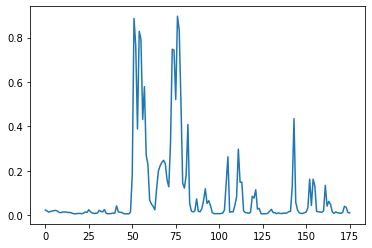

In [458]:
plt.plot(bbox_list[:, 4])

[51 52 54 55 73 74 76 77]
[[ 68.25032      8.372208   401.71405    280.18152      0.88625365
    1.        ]
 [ 74.030396     5.317093   402.05447    279.4638       0.7635024
    1.        ]
 [ 82.68677      6.746109   392.13022    265.59863      0.8280606
    1.        ]
 [ 86.75908      6.718483   370.46704    243.09406      0.7924376
    1.        ]
 [ 13.31282      6.851761   428.2627     343.08942      0.74761283
    1.        ]
 [  4.2668457    5.4868927  445.52255    354.45978      0.7436864
    1.        ]
 [122.21648      2.4857101  304.6844     152.04169      0.89593726
    1.        ]
 [126.29048      5.8270264  294.56793    147.58794      0.8342244
    1.        ]]


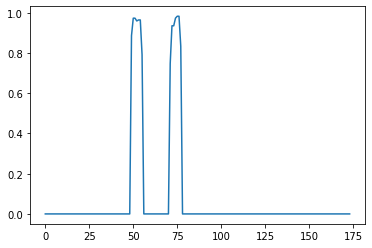

In [459]:
def detected_bbox(bboxes_list, threshold=0.6):
    
    class_list = bboxes_list[:, 4]
    class_list[class_list < threshold] = 0
    neg_list = 1 - class_list
    neg_score = neg_list[0:-2] * neg_list[1:-1] * neg_list[2:]
    pos_score = 1 - neg_score
    
    plt.plot(pos_score)
    
    detected_slices = pos_score.nonzero()[0]
    
    nonzero_slices = bboxes_list[detected_slices, 4].nonzero()[0]
    detected_slices = detected_slices[nonzero_slices]
    
    return detected_slices, bboxes_list[detected_slices, :]
    
detected_slices, detected_boxes = detected_bbox(bbox_list)
print(detected_slices)
print(detected_boxes)

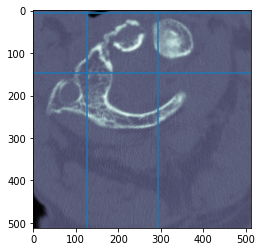

In [474]:
if len(detected_slices) > 0:
    detected_slice_index = 7
    plt.imshow(axial_tensors[detected_slices[detected_slice_index], 0, :, :], cmap='bone')
    plt.axvline(bbox_list[detected_slices[detected_slice_index],0])
    plt.axvline(bbox_list[detected_slices[detected_slice_index],2])
    plt.axhline(bbox_list[detected_slices[detected_slice_index],1])
    plt.axhline(bbox_list[detected_slices[detected_slice_index],3])

In [462]:
axial_imgs.shape

(178, 1, 341, 342)

In [463]:
axial_boundary

[75, 88, 417, 429]

In [464]:
real_boxes = np.copy(detected_boxes)
real_boxes[:, :4] =  real_boxes[:, :4] / (512 / axial_imgs.shape[-1])
real_boxes[:, [0, 2]] += axial_boundary[0]
real_boxes[:, [1, 3]] += axial_boundary[1]
real_boxes

array([[120.58908   ,  93.59238   , 343.33243   , 275.1525    ,
          0.88625365,   1.        ],
       [124.44999   ,  91.55165   , 343.5598    , 274.6731    ,
          0.7635024 ,   1.        ],
       [130.23218   ,  92.50619   , 336.93073   , 265.4116    ,
          0.8280606 ,   1.        ],
       [132.95236   ,  92.48774   , 322.4604    , 250.37923   ,
          0.7924376 ,   1.        ],
       [ 83.89255   ,  92.57676   , 361.0661    , 317.173     ,
          0.74761283,   1.        ],
       [ 77.85012   ,  91.66507   , 372.59515   , 324.76807   ,
          0.7436864 ,   1.        ],
       [156.63678   ,  89.66038   , 278.51965   , 189.5591    ,
          0.89593726,   1.        ],
       [159.3581    ,  91.89227   , 271.76218   , 186.58414   ,
          0.8342244 ,   1.        ]], dtype=float32)

In [475]:
real_slice_numbers = detected_slices + start_axial_index
real_slice_numbers

array([ 77,  78,  80,  81,  99, 100, 102, 103])

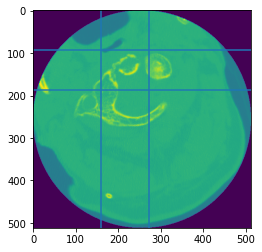

In [480]:
plt.imshow(imgs[102])
plt.axvline(real_boxes[7, 0])
plt.axvline(real_boxes[7, 2])
plt.axhline(real_boxes[7, 1])
plt.axhline(real_boxes[7, 3])

## segmentation

In [481]:
sagittal_indices = (real_boxes[:, 2] - real_boxes[:, 0]) // 2
sagittal_indices = [int(x) for x in sagittal_indices]
sagittal_indices

[111, 109, 103, 94, 138, 147, 60, 56]

In [ ]:
coronal_indices = (real_boxes[:, 3] - real_boxes[:, 1]) // 2
coronal_indices = [int(x) for x in coronal_indices]
coronal_indices